In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("/content/energy_consumption.csv")
data.head()

,DATE,ENERGY_INDEX
0,01/1939,3.3842
1,02/1939,3.4100
2,03/1939,3.4875
3,04/1939,3.5133
4,05/1939,3.5133


## Test Train split in 80:20 ratio

In [ ]:
# Perform the train-test split
train_size = 0.8  # 80% for training
split_index = int(len(data) * train_size)

train_data = data.iloc[:split_index]
valid_data = data.iloc[split_index:]
# Display the train and test data
print("Training Data:")
print(train_data)
print("\nValidation Data:")
print(valid_data)

Training Data:
        DATE  ENERGY_INDEX
0    01/1939        3.3842
1    02/1939        3.4100
2    03/1939        3.4875
3    04/1939        3.5133
4    05/1939        3.5133
..       ...           ...
770  03/2003       94.8015
771  04/2003       85.3124
772  05/2003       85.7418
773  06/2003       91.3695
774  07/2003      102.5243

[775 rows x 2 columns]

Validation Data:
        DATE  ENERGY_INDEX
775  08/2003      104.7716
776  09/2003       93.1841
777  10/2003       86.7534
778  11/2003       88.8280
779  12/2003      103.8162
..       ...           ...
964  05/2019       91.9046
965  06/2019       98.4397
966  07/2019      112.9469
967  08/2019      111.6645
968  09/2019      102.2911

[194 rows x 2 columns]


## Converting date as Index

In [ ]:
train_data.timestamp = pd.to_datetime(train_data["DATE"], format="%m/%Y")  # %b for abbreviated month name, %y for two-digit year
train_data.index = train_data.timestamp
valid_data.timestamp = pd.to_datetime(valid_data["DATE"], format="%m/%Y")  # %b for abbreviated month name, %y for two-digit year
valid_data.index = valid_data.timestamp
train_data.head()

,DATE,ENERGY_INDEX
DATE,,
1939-01-01,01/1939,3.3842
1939-02-01,02/1939,3.4100
1939-03-01,03/1939,3.4875
1939-04-01,04/1939,3.5133
1939-05-01,05/1939,3.5133


In [ ]:
valid_data.index

DatetimeIndex(['2003-08-01', '2003-09-01', '2003-10-01', '2003-11-01',
               '2003-12-01', '2004-01-01', '2004-02-01', '2004-03-01',
               '2004-04-01', '2004-05-01',
               ...
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01'],
              dtype='datetime64[ns]', name='DATE', length=194, freq=None)

The date values are starting from 2039 which is incorrect.
Need to update the date index and plot the timeseries

In [ ]:
# Adjust the years in the index
train_data.index = train_data.index.map(lambda x: x.replace(year=x.year - 100) if x.year >= 2038 else x)
valid_data.index = valid_data.index.map(lambda x: x.replace(year=x.year - 100) if x.year >= 2038 else x)

In [ ]:
train_data.head()

,DATE,ENERGY_INDEX
DATE,,
1939-01-01,01/1939,3.3842
1939-02-01,02/1939,3.4100
1939-03-01,03/1939,3.4875
1939-04-01,04/1939,3.5133
1939-05-01,05/1939,3.5133


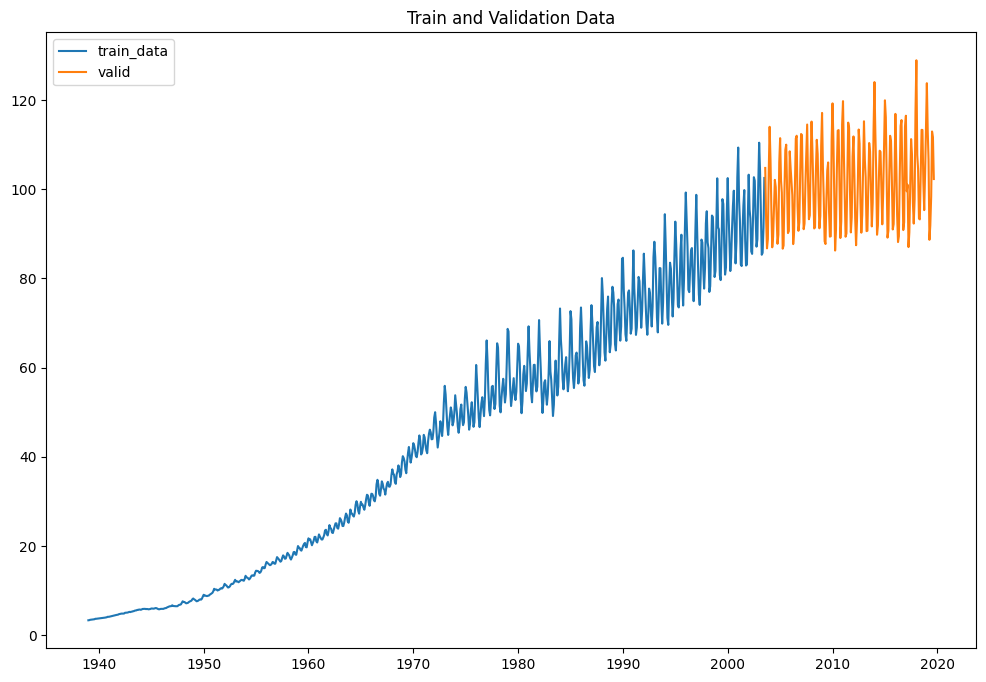

In [ ]:
# Plotting the corrected data
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data['ENERGY_INDEX'], label='train_data')
plt.plot(valid_data.index, valid_data['ENERGY_INDEX'], label='valid')
plt.legend(loc='best')
plt.title("Train and Validation Data")
plt.show()

# Stationarity Test

In [ ]:
# dickey fuller, KPSS
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
def adf_test(timeseries):

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
adf_test(train_data['ENERGY_INDEX'])

Results of Dickey-Fuller Test:
Test Statistic                   1.589352
p-value                          0.997825
#Lags Used                      15.000000
Number of Observations Used    759.000000
Critical Value (1%)             -3.438995
Critical Value (5%)             -2.865355
Critical Value (10%)            -2.568802
dtype: float64


 If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary). **Here test statistic is > than critical. Hence series is not stationary**

In [ ]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [ ]:
kpss_test(train_data['ENERGY_INDEX'])

Results of KPSS Test:
Test Statistic            4.390342
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-17-6e2183a16546>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). Here test statistic is > than critical. Hence series is not stationary

Alternatively, we can use the p-value to make the inference. If p-value is less than 0.05, we can reject the null hypothesis. And say that the series is not stationary.

# Making Series Stationary

Stabilizing the mean by Differencing the series. Removing trend;

Using 1 level differencing

In [ ]:
train_data['ENERGY_INDEX_diff'] = train_data['ENERGY_INDEX'] - train_data['ENERGY_INDEX'].shift(1)

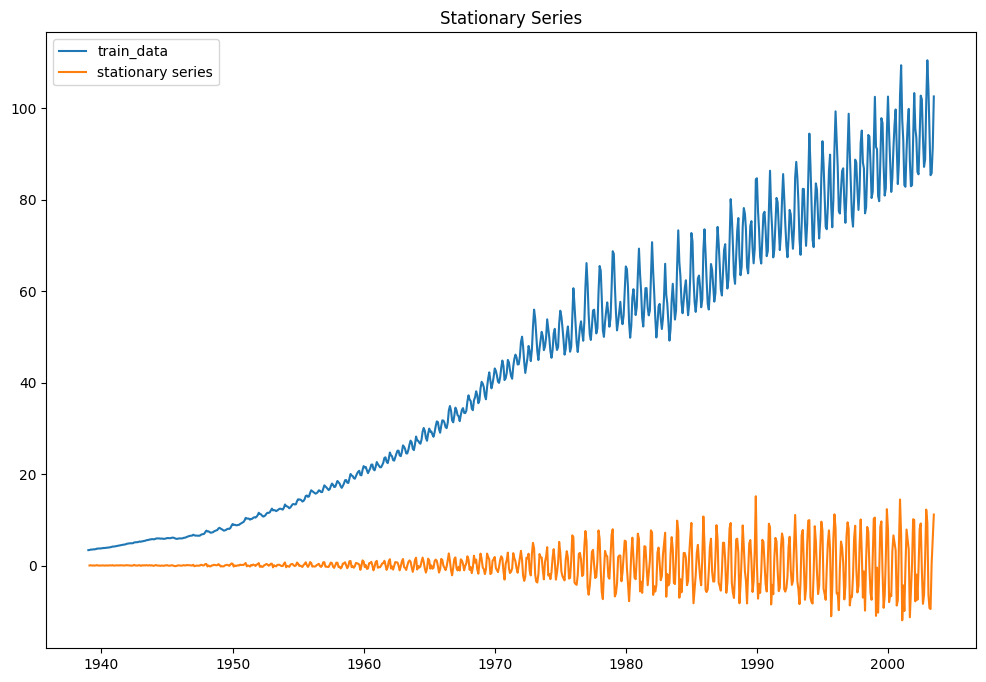

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['ENERGY_INDEX'], label='train_data')
plt.plot(train_data.index,train_data['ENERGY_INDEX_diff'], label='stationary series')
plt.legend(loc='best')
plt.title("Stationary Series")
plt.show()

Need to remove variance from the data
## Therefore transform the data using log transform or Box-cox transform



In [ ]:
train_data['ENERGY_INDEX_log'] = np.log(train_data['ENERGY_INDEX'])
train_data['ENERGY_INDEX_log_diff'] = train_data['ENERGY_INDEX_log'] - train_data['ENERGY_INDEX_log'].shift(1)

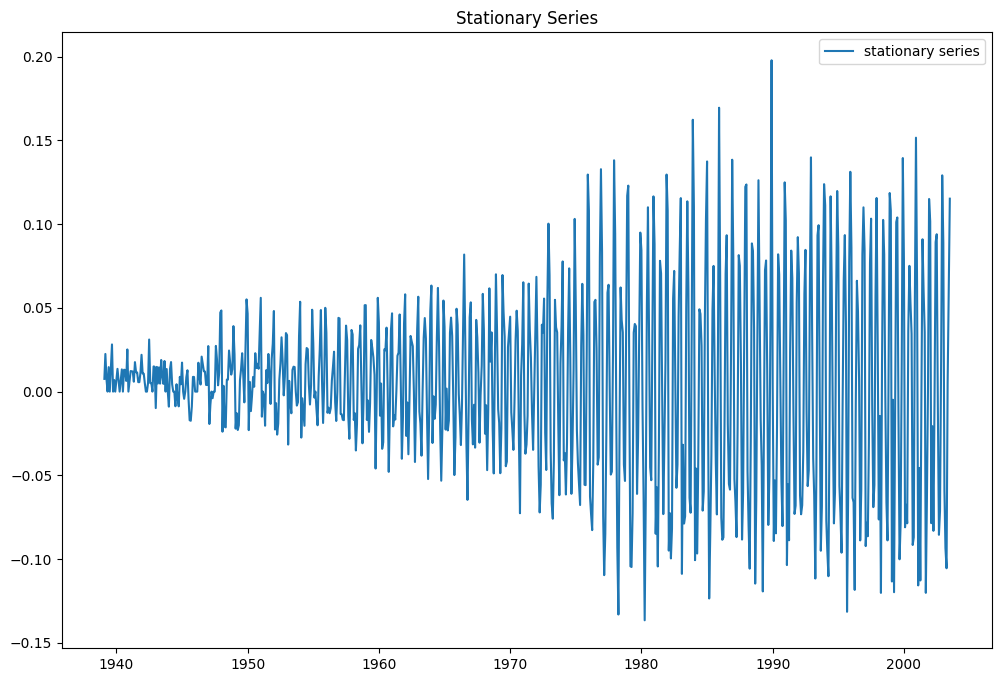

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index,train_data['ENERGY_INDEX_log_diff'], label='stationary series')
plt.legend(loc='best')
plt.title("Stationary Series")
plt.show()

## Hence using Box-cox transform for removing variance

In [ ]:
from scipy import stats

In [ ]:
transformed_data, lambda_value = stats.boxcox(train_data['ENERGY_INDEX'], lmbda=None)

In [ ]:
lambda_value

0.46979901637288507

In [ ]:
train_data['ENERGY_INDEX_trans'] = transformed_data
train_data['ENERGY_INDEX_trans_diff'] = train_data['ENERGY_INDEX_trans'] - train_data['ENERGY_INDEX_trans'].shift(1)

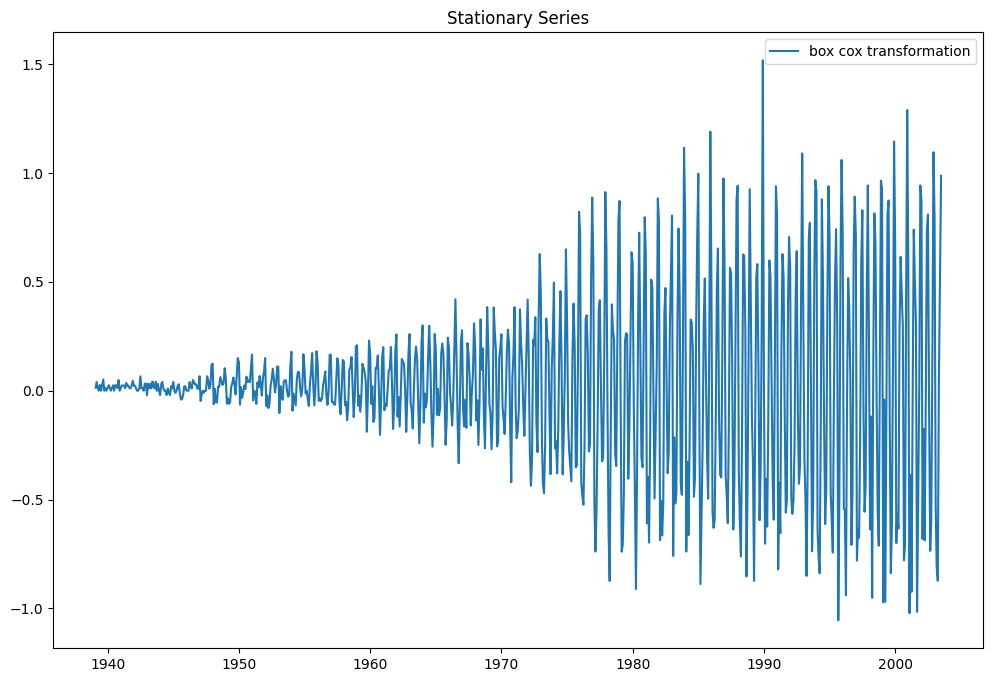

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index,train_data['ENERGY_INDEX_trans_diff'], label='box cox transformation')
plt.legend(loc='best')
plt.title("Stationary Series")
plt.show()

## Checking if the series is stationary now

## For log tranform

In [ ]:
adf_test(train_data['ENERGY_INDEX_log_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -5.318775
p-value                          0.000005
#Lags Used                      21.000000
Number of Observations Used    752.000000
Critical Value (1%)             -3.439076
Critical Value (5%)             -2.865391
Critical Value (10%)            -2.568821
dtype: float64


In [ ]:
kpss_test(train_data['ENERGY_INDEX_log_diff'].dropna())

Results of KPSS Test:
Test Statistic            0.791973
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-17-6e2183a16546>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


## For Box-cox transform

In [ ]:
adf_test(train_data['ENERGY_INDEX_trans_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.607651e+00
p-value                        6.605466e-14
#Lags Used                     2.100000e+01
Number of Observations Used    7.520000e+02
Critical Value (1%)           -3.439076e+00
Critical Value (5%)           -2.865391e+00
Critical Value (10%)          -2.568821e+00
dtype: float64


In [ ]:
kpss_test(train_data['ENERGY_INDEX_trans_diff'].dropna())

Results of KPSS Test:
Test Statistic            0.099905
p-value                   0.100000
Lags Used                36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-17-6e2183a16546>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


## Both test for log transform confirms that series is stationary now. Hence going ahead with log transform

## Fitting the series on ARIMA AND SARIMA Models

# ACF and PACF plots

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

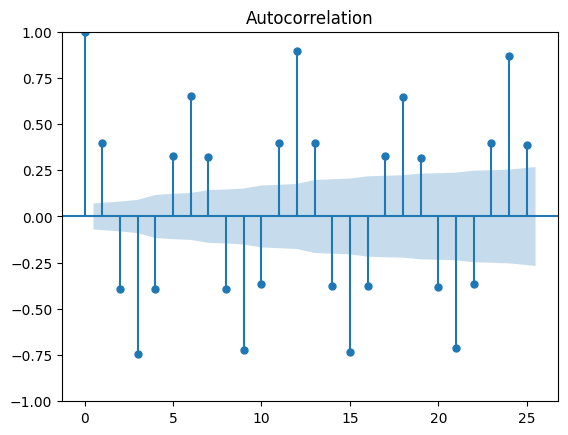

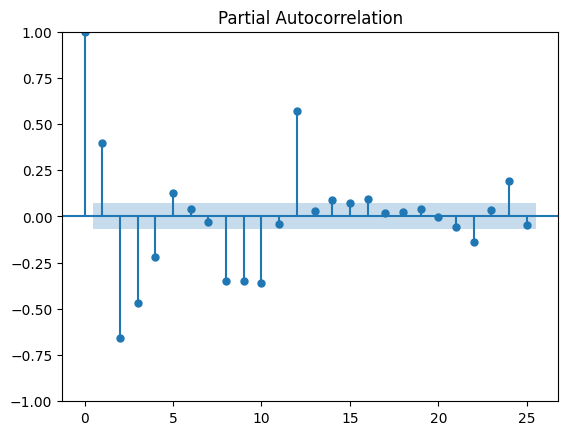

In [ ]:
plot_acf(train_data['ENERGY_INDEX_log_diff'].dropna(), lags=25)
plot_pacf(train_data['ENERGY_INDEX_log_diff'].dropna(), lags=25)
plt.show()

   - p value is the lag value where the PACF chart crosses the confidence interval for the first time. It can be noticed that in this case p=1.

   - q value is the lag value where the ACF chart crosses the confidence interval for the first time. It can be noticed that in this case it does not cross the confidence level.
   Hence considering q = 1. No impact

   - Now we will make the ARIMA model as we have the p,q values.

# ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming train_data['ENERGY_INDEX_log'] is your transformed dataset
model = ARIMA(train_data['ENERGY_INDEX_log'], order=(1, 1, 0))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
valid_data.shape

(194, 2)

In [ ]:
# gernerate forecasts
output = model_fit.forecast(194)
# Assuming output is a pandas.Series with 194 forecasted values
valid_data['Arima'] = output.values

In [ ]:
# to deal with log transformed values
valid_data['Arima'] = np.exp(valid_data['Arima'])

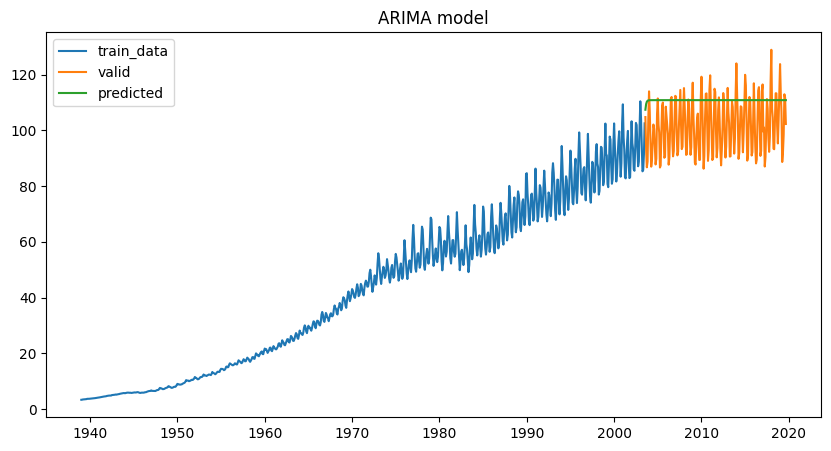

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(train_data.index, train_data['ENERGY_INDEX'], label='train_data')
plt.plot(valid_data.index, valid_data['ENERGY_INDEX'], label='valid')
plt.plot(valid_data.index, valid_data['Arima'], label='predicted')

plt.legend(loc='best')
plt.title("ARIMA model")
plt.show()

In [ ]:
# calculating RMSE
rmse = sqrt(mean_squared_error(valid_data['ENERGY_INDEX'], valid_data['Arima']))
print('The RMSE value for ARIMA is', rmse)

The RMSE value for ARIMA is 13.286551731869304


# SARIMA

In [ ]:
from statsmodels.tsa.statespace import sarimax

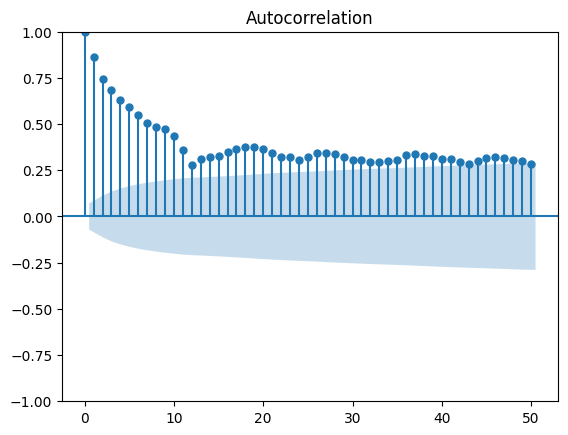

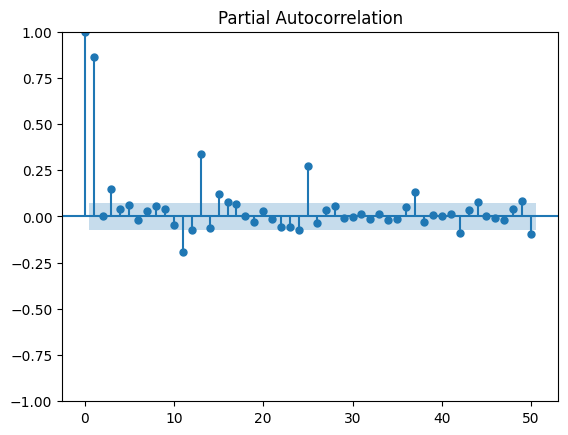

In [ ]:
plot_acf(train_data['ENERGY_INDEX_log_diff'].dropna(), lags=50)
plot_pacf(train_data['ENERGY_INDEX_log_diff'].dropna(), lags=50)
plt.show()

In [ ]:
train_data['ENERGY_INDEX_log'] = np.log(train_data['ENERGY_INDEX'])
train_data['ENERGY_INDEX_log_diff'] = train_data['ENERGY_INDEX_log'] - train_data['ENERGY_INDEX_log'].shift(12)

In [ ]:
train_data['ENERGY_INDEX_log_diff'].head(15)

DATE
1939-01-01         NaN
1939-02-01         NaN
1939-03-01         NaN
1939-04-01         NaN
1939-05-01         NaN
1939-06-01         NaN
1939-07-01         NaN
1939-08-01         NaN
1939-09-01         NaN
1939-10-01         NaN
1939-11-01         NaN
1939-12-01         NaN
1940-01-01    0.108408
1940-02-01    0.114402
1940-03-01    0.098680
Name: ENERGY_INDEX_log_diff, dtype: float64

In [ ]:
# fit model
model = sarimax.SARIMAX(train_data['ENERGY_INDEX_log'], seasonal_order=(1,1,0,12), order=(1,1,1))
fit1 = model.fit()

# make predictions
valid_data['SARIMA'] = fit1.predict(start="2003-08-01", end="2019-09-01", dynamic=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
valid_data['SARIMA'] = np.exp(valid_data['SARIMA'])

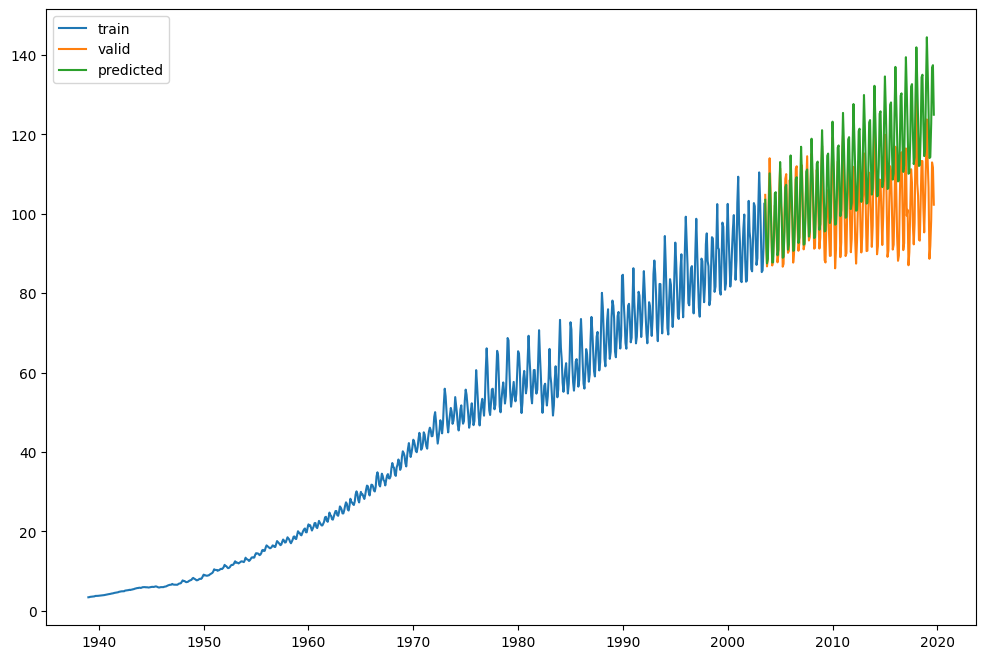

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(train_data['ENERGY_INDEX'],  label='train')
plt.plot(valid_data['ENERGY_INDEX'],  label='valid')
plt.plot(valid_data['SARIMA'],  label='predicted')
plt.legend(loc='best')
plt.show()

In [ ]:
# calculating RMSE
rmse = sqrt(mean_squared_error(valid_data['ENERGY_INDEX'], valid_data['SARIMA']))
print('The RMSE value for SARIMA is', rmse)

The RMSE value for SARIMA is 12.543951487859562
